In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.optimize import curve_fit

from typing import Literal, Union

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib as mpl

from qs_mps.utils import create_sequential_colors
from qs_mps.applications.Z2.utils import get_cx, get_cy, find_closest_value, asymptotic_fit, plot_asymptotic_fit, arithmetic_average
from qs_mps.applications.Z2.relevant_observables import static_potential, static_potential_chis, static_potential_exact_L, static_potential_Ls
# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

font = {'family': 'serif', 'size': 20}
plt.rcParams.update({'font.family': font['family'], 'font.size': font['size']})

model = "Z2_dual"
path = "marcos"
cx = [3,37]
cy = [3,3]
# cx = None
# cy = None

if model == "Ising":
    model_path = "0_ISING"

elif model == "Z2_dual":
    model_path = "1_Z2"
    param_label = "h"
    boundcond = "obc"
    if cx == None:
        sector = "vacuum_sector"
    else:
        sector = f"{len(cx)}_particle(s)_sector"

elif model == "ANNNI":
    model_path = "2_ANNNI"

elif model == "Cluster":
    model_path = "3_CLUSTER"
else:
    raise SyntaxError("Model not valid. Choose among 'Ising', 'Z2', 'ANNNI', 'Cluster'")
# take the path and precision to save files
# if we want to save the tensors we save them locally because they occupy a lot of memory
if path == "pc":
    path_tensor = f"C:/Users/HP/Desktop/projects/1_Z2"
    parent_path = path_tensor
    # parent_path = "G:/My Drive/projects/1_Z2"
    # path_tensor = "D:/code/projects/1_Z2"
elif path == "mac":
    # parent_path = "/Users/fradm98/Google Drive/My Drive/projects/1_Z2"
    path_tensor = "/Users/fradm98/Desktop/projects/1_Z2"
    parent_path = path_tensor
elif path == "marcos":
    # parent_path = "/Users/fradm/Google Drive/My Drive/projects/1_Z2"
    path_tensor = "/Users/fradm/Desktop/projects/1_Z2"
    parent_path = path_tensor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Charge Sector Analysis

We want to explore the two particle sector of you $Z_2$ pure lattice gauge theory. 
The study of the potential already can tell us more about the physics of the system. 

From the decoupling phase at small values of the Eletric coupling constant $g$, the charges are free so that there is no attractive potential between the two charges. If we express the potential as the difference between the vacuum ground state and the two charges ground state, in the **decoupling phase**, this quantity corresponds to the free energy of the particles.

Entering the confining phase, the energy between the charges forms a string of electric flux which is dominated by fluctuations. This is called the **roughening phase**. This phase is supposed to be dominant for a certain region of coupling values up to the roughening transition which is said to be an infinite order phase transition. 

After the transition, for large values of eletric coupling, the negative electric field is confined along the shortest path separating the two charges, reaching indeed the **confinig phase**.

Thus, we will see in this notebook the potential in these different phases

## Study of the potential $V(g,R)$

The static potential, according with what has been just said, depends on the electric coupling $g$ but also on the distance between the two charges defined as $R$.
The potential in the roughening phase seems to have a correction term

$$ V(g,R) = \sigma R + \mu + \gamma\frac{1}{R} + O\left(\frac{1}{R^2}\right) \quad .$$

But there are systematic and statistical errors to take into account because of our numerical simulations.
The accuracy of the ground state energy is limited by the bond dimension $\chi$ and finite size effects could arise because of the lattice with shape $l$ x $L$.

Thus, we now focus on some specific values of $g,R$, we fix the lattice and find the value of the potential for infinite bond dimension.
Once we have eliminated the dependency of the potential from the bond dimension, we can study the finite size effects. Finally we will get the $V(g,R)$ and we can extract the string tension $\sigma$ and the luscher term $\gamma$.

# Study of the potential $V(g,R,L,\chi)$

The bond dimension $\chi$ is our free parameter

In [86]:
# free param
chis = [16,32,64,128]

# secondary fixed params
bc = "pbc"
npoints, h_i, h_f = 61, 0.4, 1.0
interval = np.linspace(h_i,h_f,npoints)

# fixed params
g = 0.4
l, L, R = 3, 30, 24
g = find_closest_value(interval, g)

# get the potential vs bond dimension
potentials = static_potential_chis(g,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor)

we search for g=0.4


<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_18973/2777465946.py:3: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel("$1/\chi$")
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_18973/2777465946.py:5: SyntaxWarning: invalid escape sequence '\c'
  plt.title("Static Potential $V(g,R,l$x$L)$ $vs$ $1/\chi$")


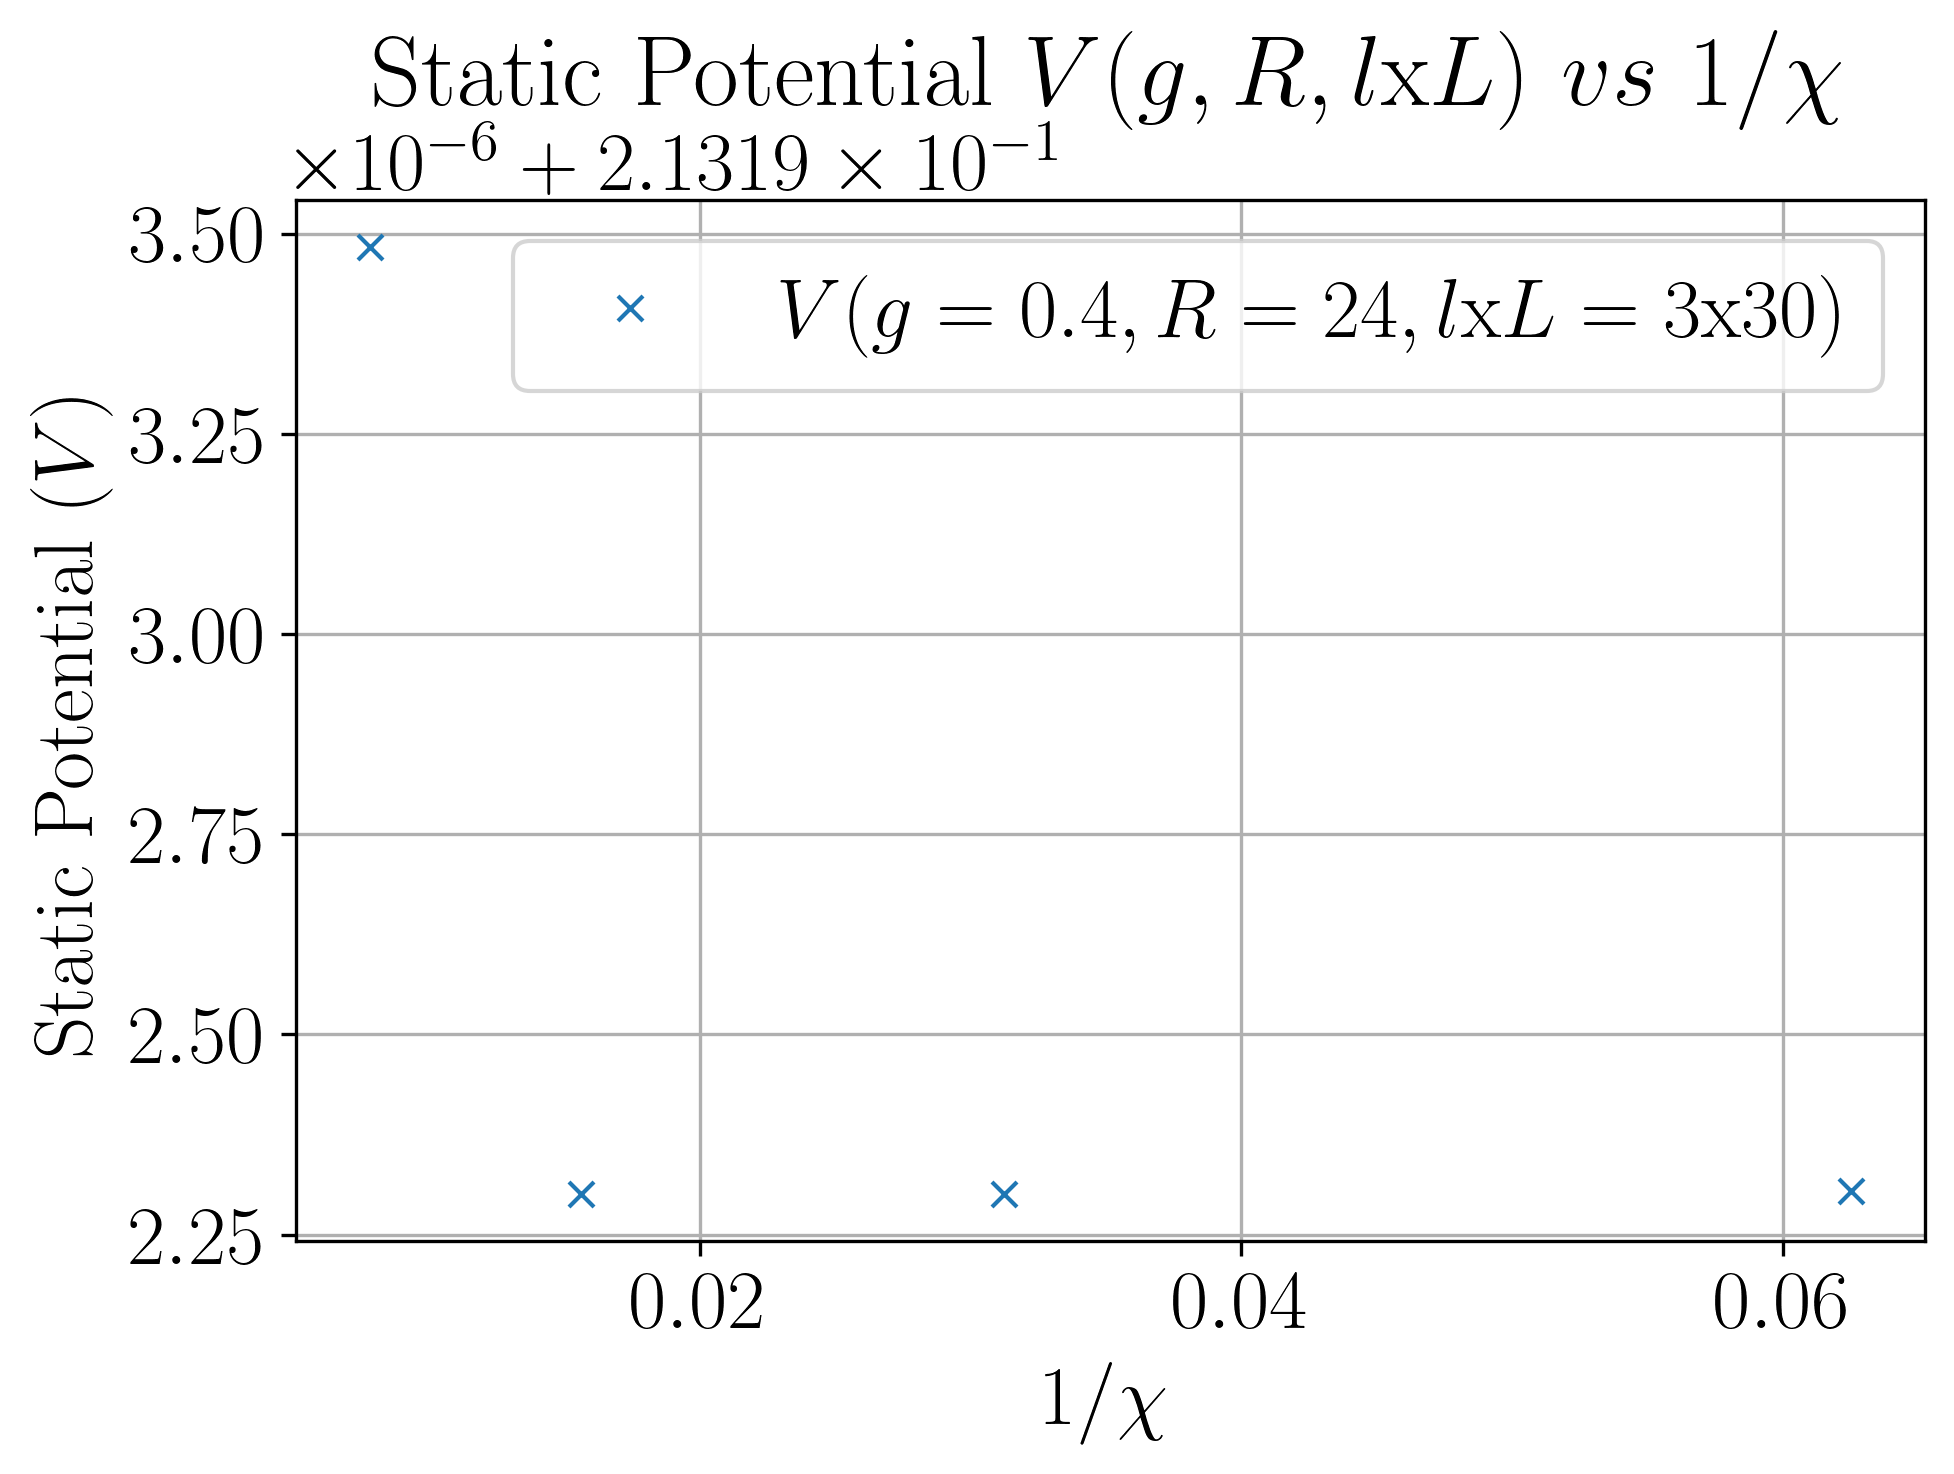

In [87]:
plt.plot([1/chi for chi in chis], potentials, 'x', label=f"$V(g={round(g,2)}, R={R}, l$x$L={l}$x${L})$")

plt.xlabel("$1/\chi$")
plt.ylabel("Static Potential $(V)$")
plt.title("Static Potential $V(g,R,l$x$L)$ $vs$ $1/\chi$")
plt.legend()
plt.grid(True)


### Asymptotic fit

Fitted exp observable in function of chi:


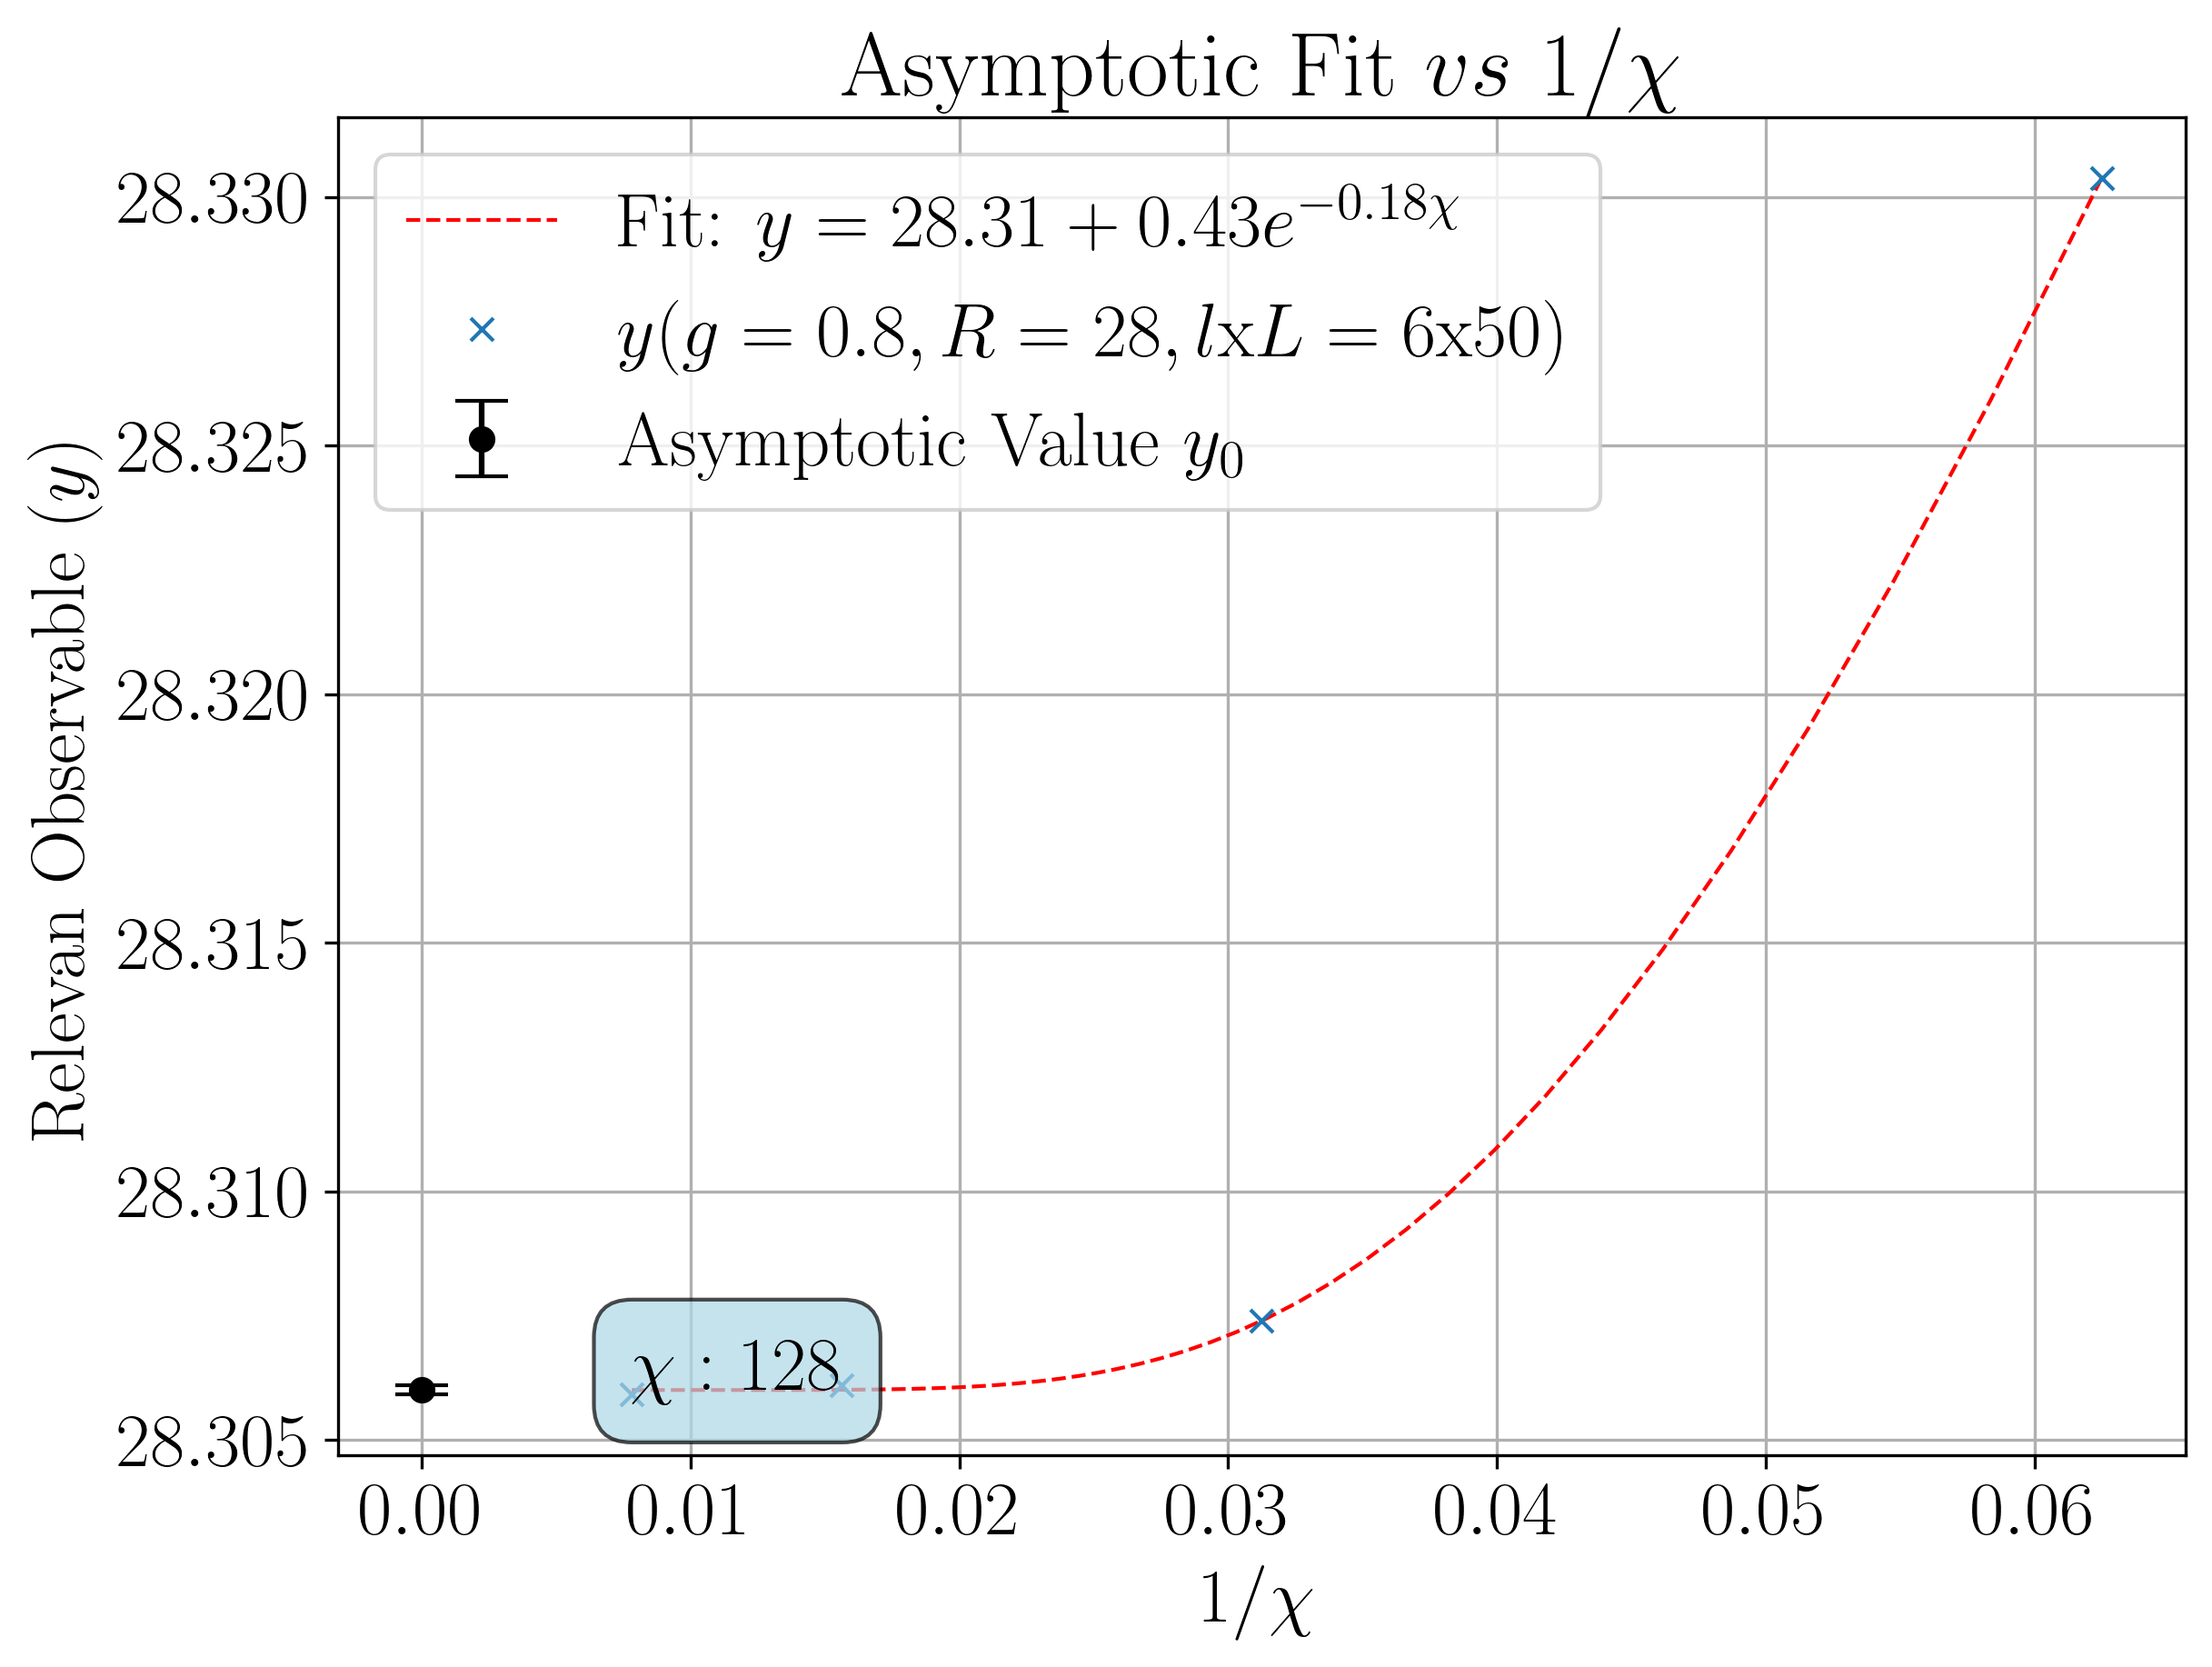

In [16]:
popt, errs = asymptotic_fit(potentials, chis, 'chi', fit_func="exp")
plot_asymptotic_fit(potentials, chis, 'chi', popt, errs, fit_func="exp", fixed_params=[g,R,l,L])

We have found that, taking small and large bond dimensions $\chi$, the best fit is the exponential one.
Now we can iterate for different values of $g$ and $R$ to move to the next step, that is, taking care of finite size lattice effects.

# Study of the potential $V(g,R,L)$

Now we fix $g$ and $R$ and, by taking the values of V obtained for infinite $\chi$ we determine the finite size effect of our lattice in the $L$ direction.

In [43]:
Ls = [40,50]
g = 0.8
R = 28
potentials, err_L = static_potential_Ls(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
print(potentials, err_L)

[28.305911456736908, 28.30591105988583] [0.00021233732843484177, 0.00019183193307981128]


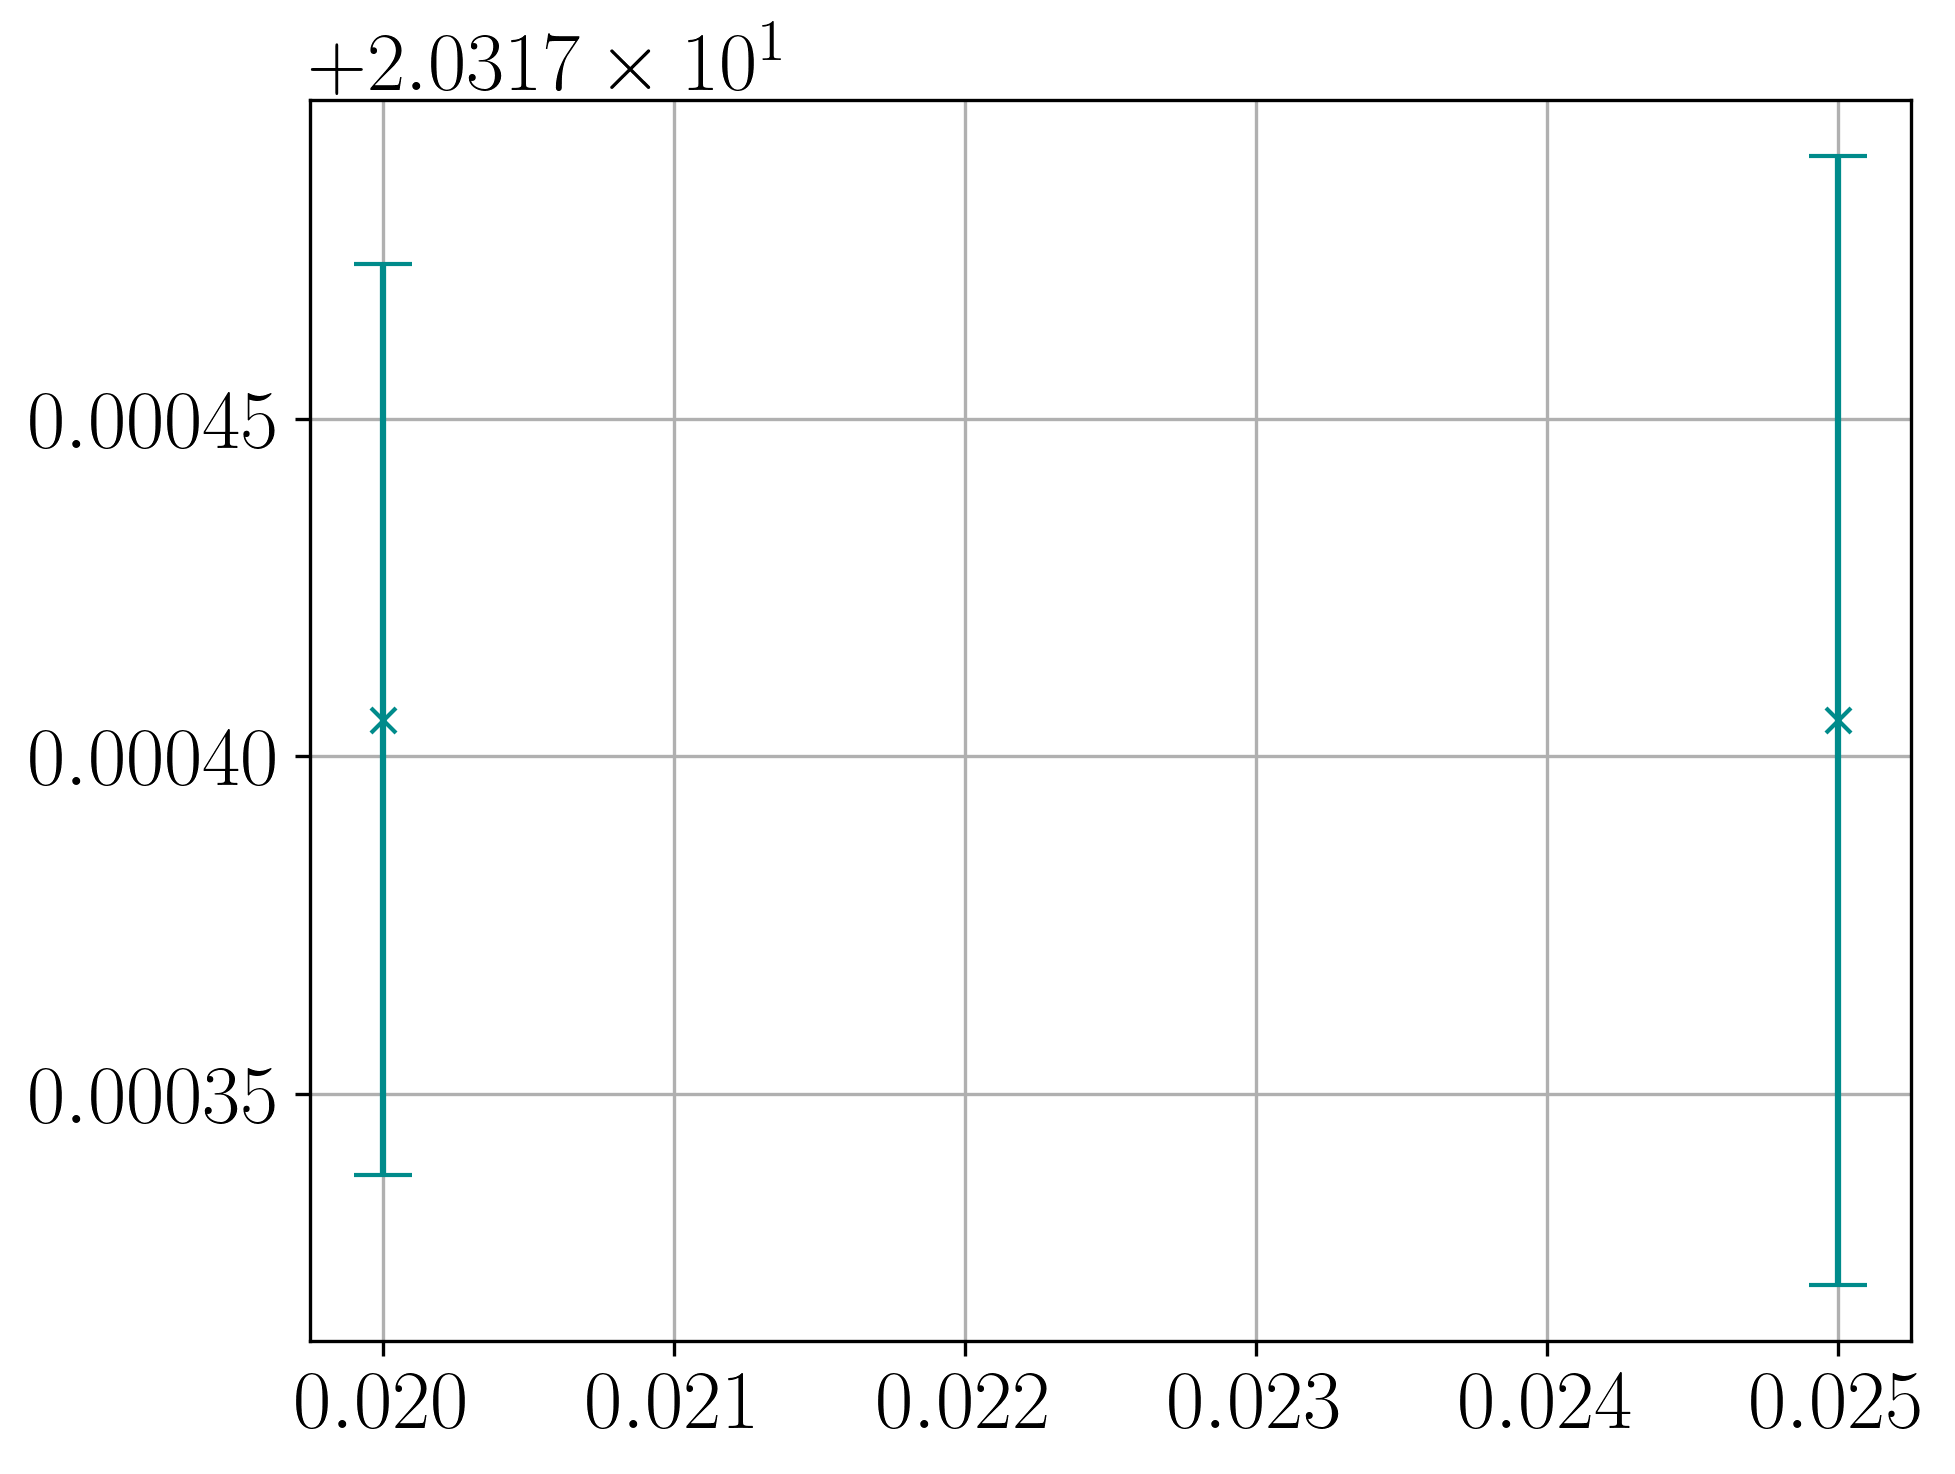

In [37]:
plt.errorbar([1/L for L in Ls], potentials, yerr=err_L, fmt='x', color='darkcyan', capsize=7)
plt.grid(True)
plt.show()

## Effect of g and R in OBC

we search for g=0.8


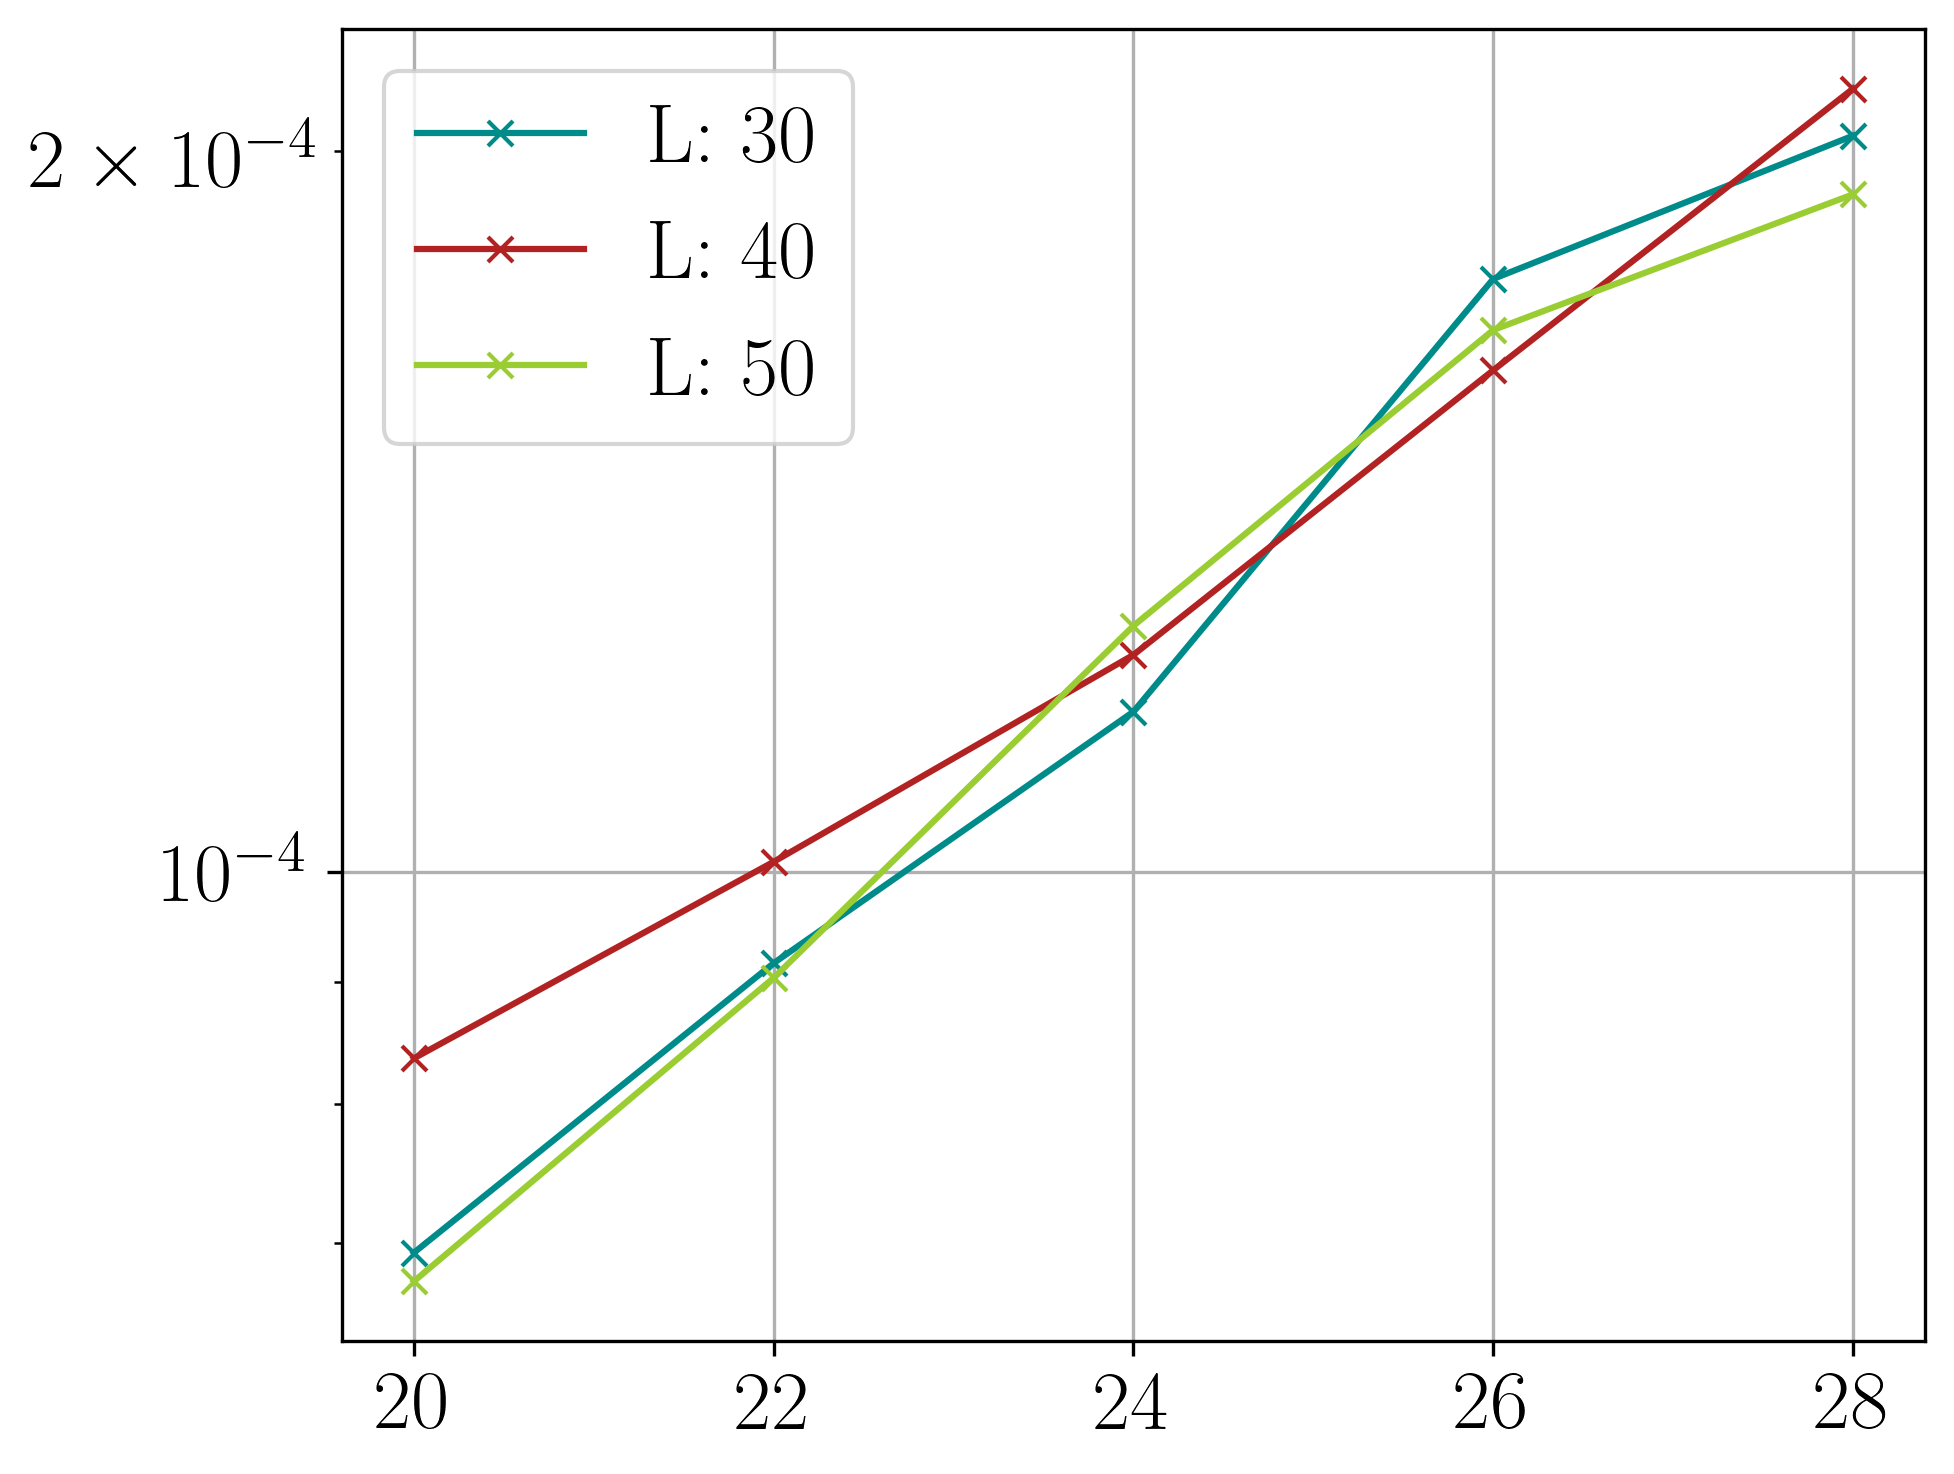

(30, 3)


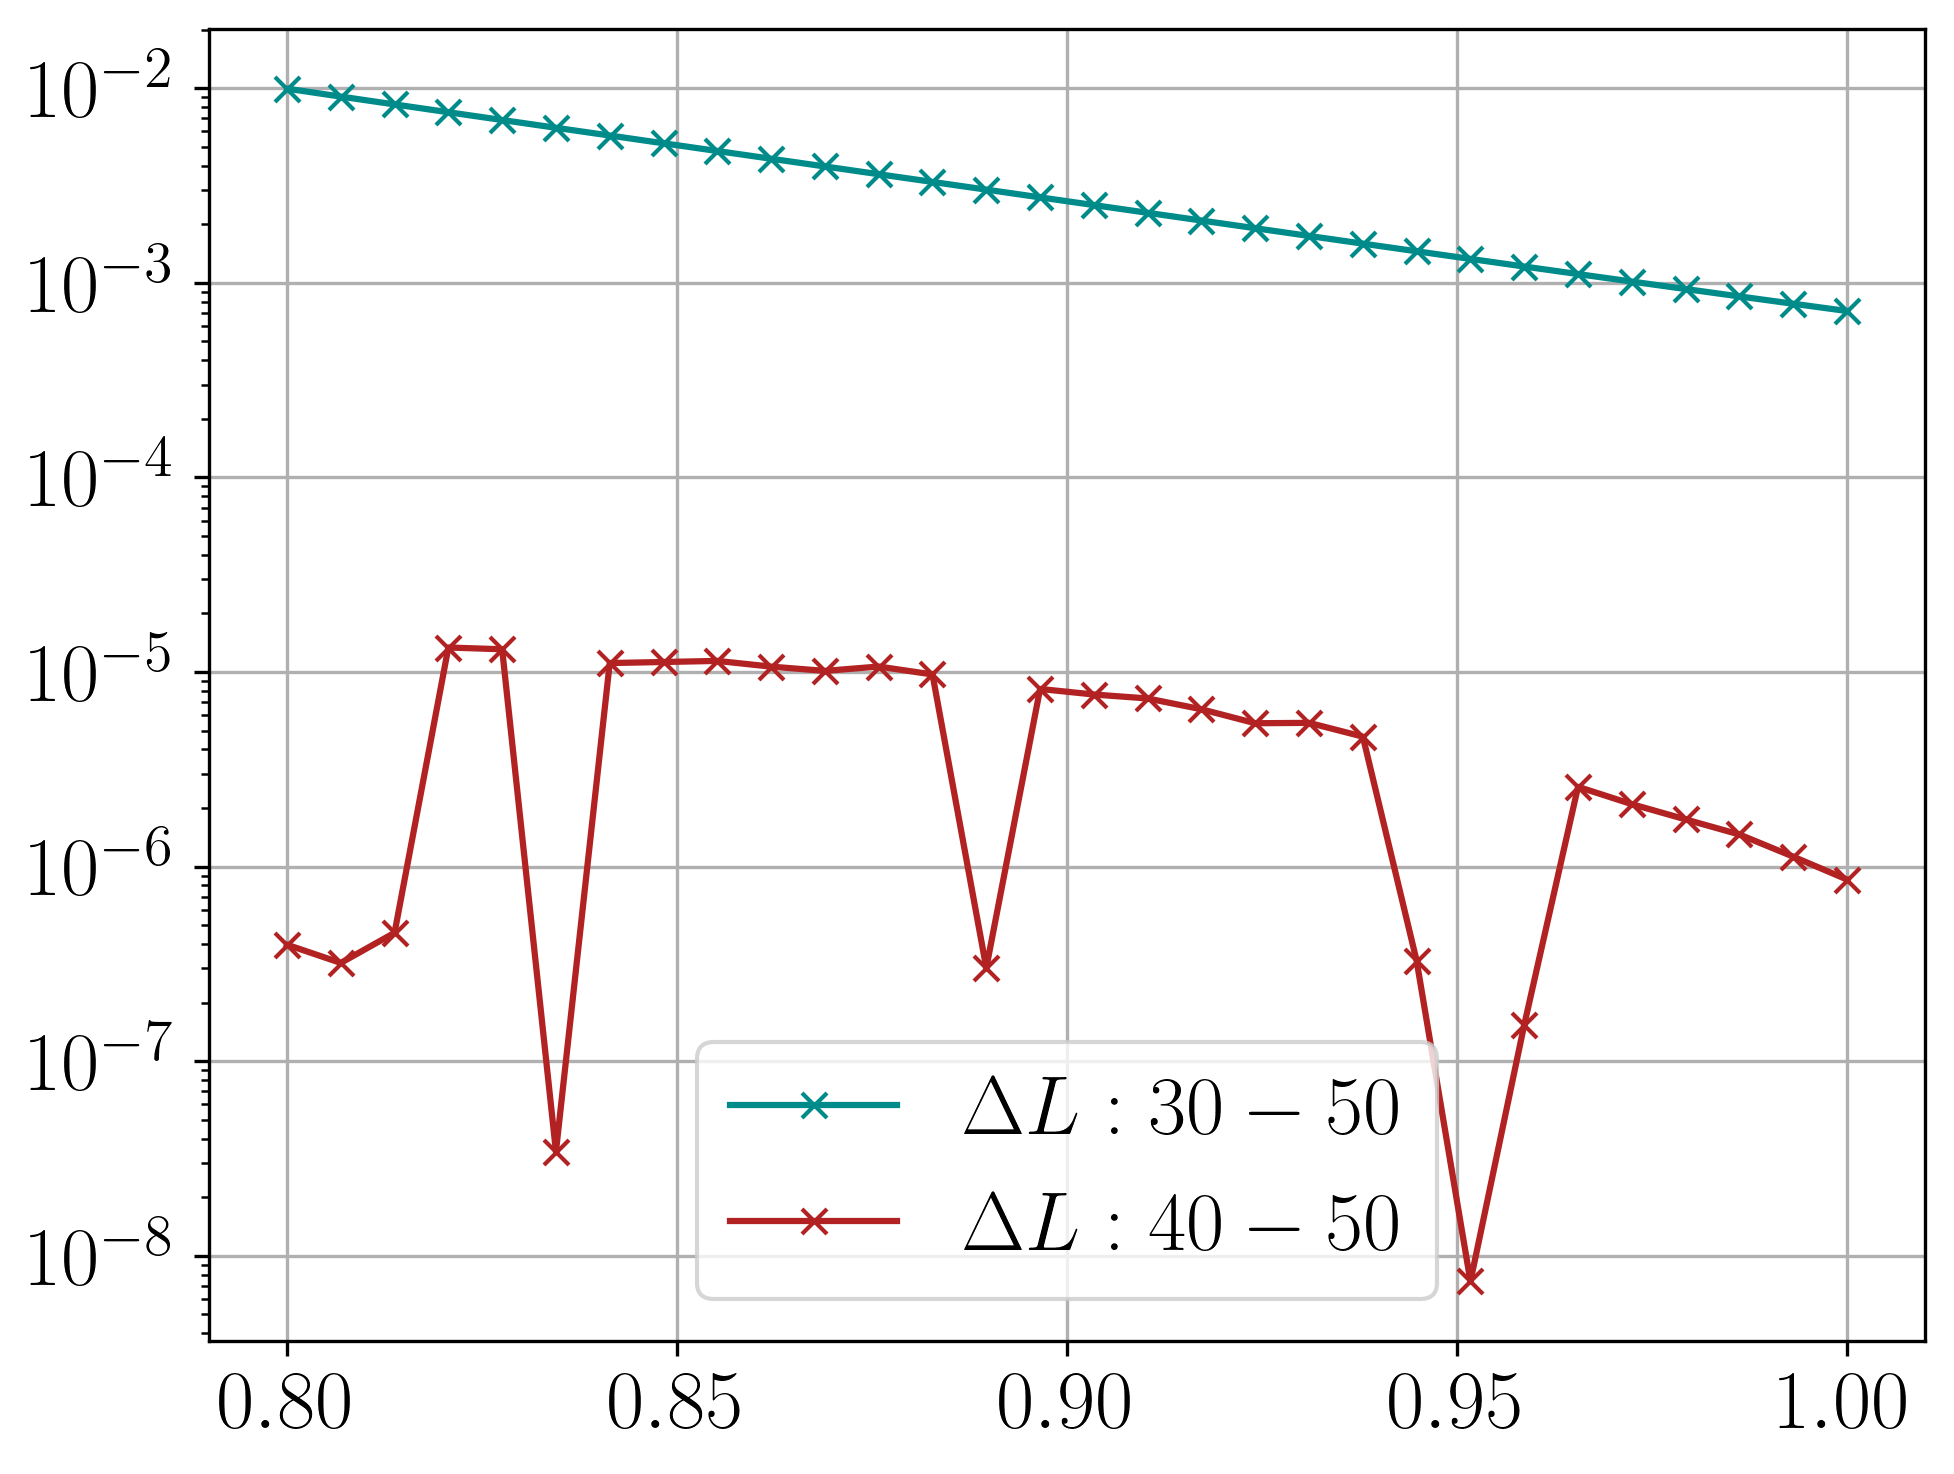

In [85]:
# free param
chis = [16,32,64,128]

# secondary fixed params
bc = "obc"
npoints, h_i, h_f = 30, 0.8, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval

# fixed params
g = 0.8
l, L, R = 6, 50, 28
g = find_closest_value(interval, g)

Rs = [20,22,24,26,28]
Ls = [30,40,50]

errs = []
colors = ["darkcyan", "firebrick", "yellowgreen", "darkorchid"]
for R in Rs:
    potentials, err_L = static_potential_Ls(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cy=cy)
    errs.append(err_L)
for i,L in enumerate(Ls):    
    plt.plot(Rs, np.asarray(errs)[:,i], marker='x', color=colors[i], label=f"L: {L}")
plt.grid(True)
plt.legend()
plt.yscale("log")
plt.show()

pots = []
for g in gs:
    potentials, err_L = static_potential_Ls(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cy=cy)
    pots.append(potentials)

L_last = Ls.pop()
for i,L in enumerate(Ls):
    plt.plot(gs, np.abs(np.asarray(pots)[:,i]-np.asarray(pots)[:,-1]), marker='x', color=colors[i], label=f"$\\Delta L: {L}-{L_last}$")
plt.grid(True)
plt.legend()
plt.yscale("log")
plt.show()

## Effect of g and R in PBC

In [ ]:
# free param
chis = [16,32,64,128]

# secondary fixed params
bc = "obc"
npoints, h_i, h_f = 30, 0.8, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval

# fixed params
g = 0.8
l, L, R = 6, 50, 28
g = find_closest_value(interval, g)

Rs = [20,22,24,26,28]
Ls = [30,40,50]


# free param
chis = [16,32,64]

# secondary fixed params
bc = "pbc"
npoints, h_i, h_f = 61, 0.4, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval

# fixed params
g = 0.4
l, L, R = 3, 30, 24
g = find_closest_value(interval, g)

Rs = [18,20,22,24]
Ls = [30]
ls = [3,4]
cy = None

errs = []
colors = ["darkcyan", "firebrick", "yellowgreen", "darkorchid"]
for i,l in enumerate(ls):
    errs = []
    for R in Rs:
        potentials, err_L = static_potential_Ls(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cy=cy)
        errs.append(err_L)
    plt.plot(Rs, np.abs(np.asarray(errs)), marker='x', color=colors[i], label=f"l: {l}")
# for R in Rs:
#     potentials, err_L = static_potential_Ls(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cy=cy)
#     errs.append(err_L)
# for i,L in enumerate(Ls):    
#     plt.plot(Rs, np.asarray(errs)[:,i], marker='x', color=colors[i], label=f"L: {L}")

g = 0.4
l, L, R = 5, 30, 24
g = find_closest_value(interval, g)
chis = [16,32,64]
errs = []
i = 2
for R in Rs:
    potentials, err_L = static_potential_Ls(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cy=cy)
    errs.append(err_L)
plt.plot(Rs, np.abs(np.asarray(errs)), marker='x', color=colors[i], label=f"l: {l}")
plt.grid(True)
plt.legend()
plt.yscale("log")
plt.show()

cy = None

ls = [3,4]
chis = [16,32,64,128]

for i,l in enumerate(ls):
    pots = []
    for g in gs:
        potentials, err_L = static_potential_Ls(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cy=cy)
        pots.append(potentials)
    plt.plot(gs, np.abs(np.asarray(pots)), marker='x', color=colors[i], label=f"l: {l}")


g = 0.4
l, L, R = 5, 30, 24
g = find_closest_value(interval, g)
chis = [16,32,64]
pots = []
i = 2
for g in gs:
    potentials, err_L = static_potential_Ls(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor,cy=cy)
    pots.append(potentials)
plt.plot(gs, np.abs(np.asarray(pots)), marker='x', color=colors[i], label=f"l: {l}")
plt.grid(True)
plt.legend()
plt.yscale("log")
plt.show()

### Asymptotic fit

Fitted lin observable in function of L:


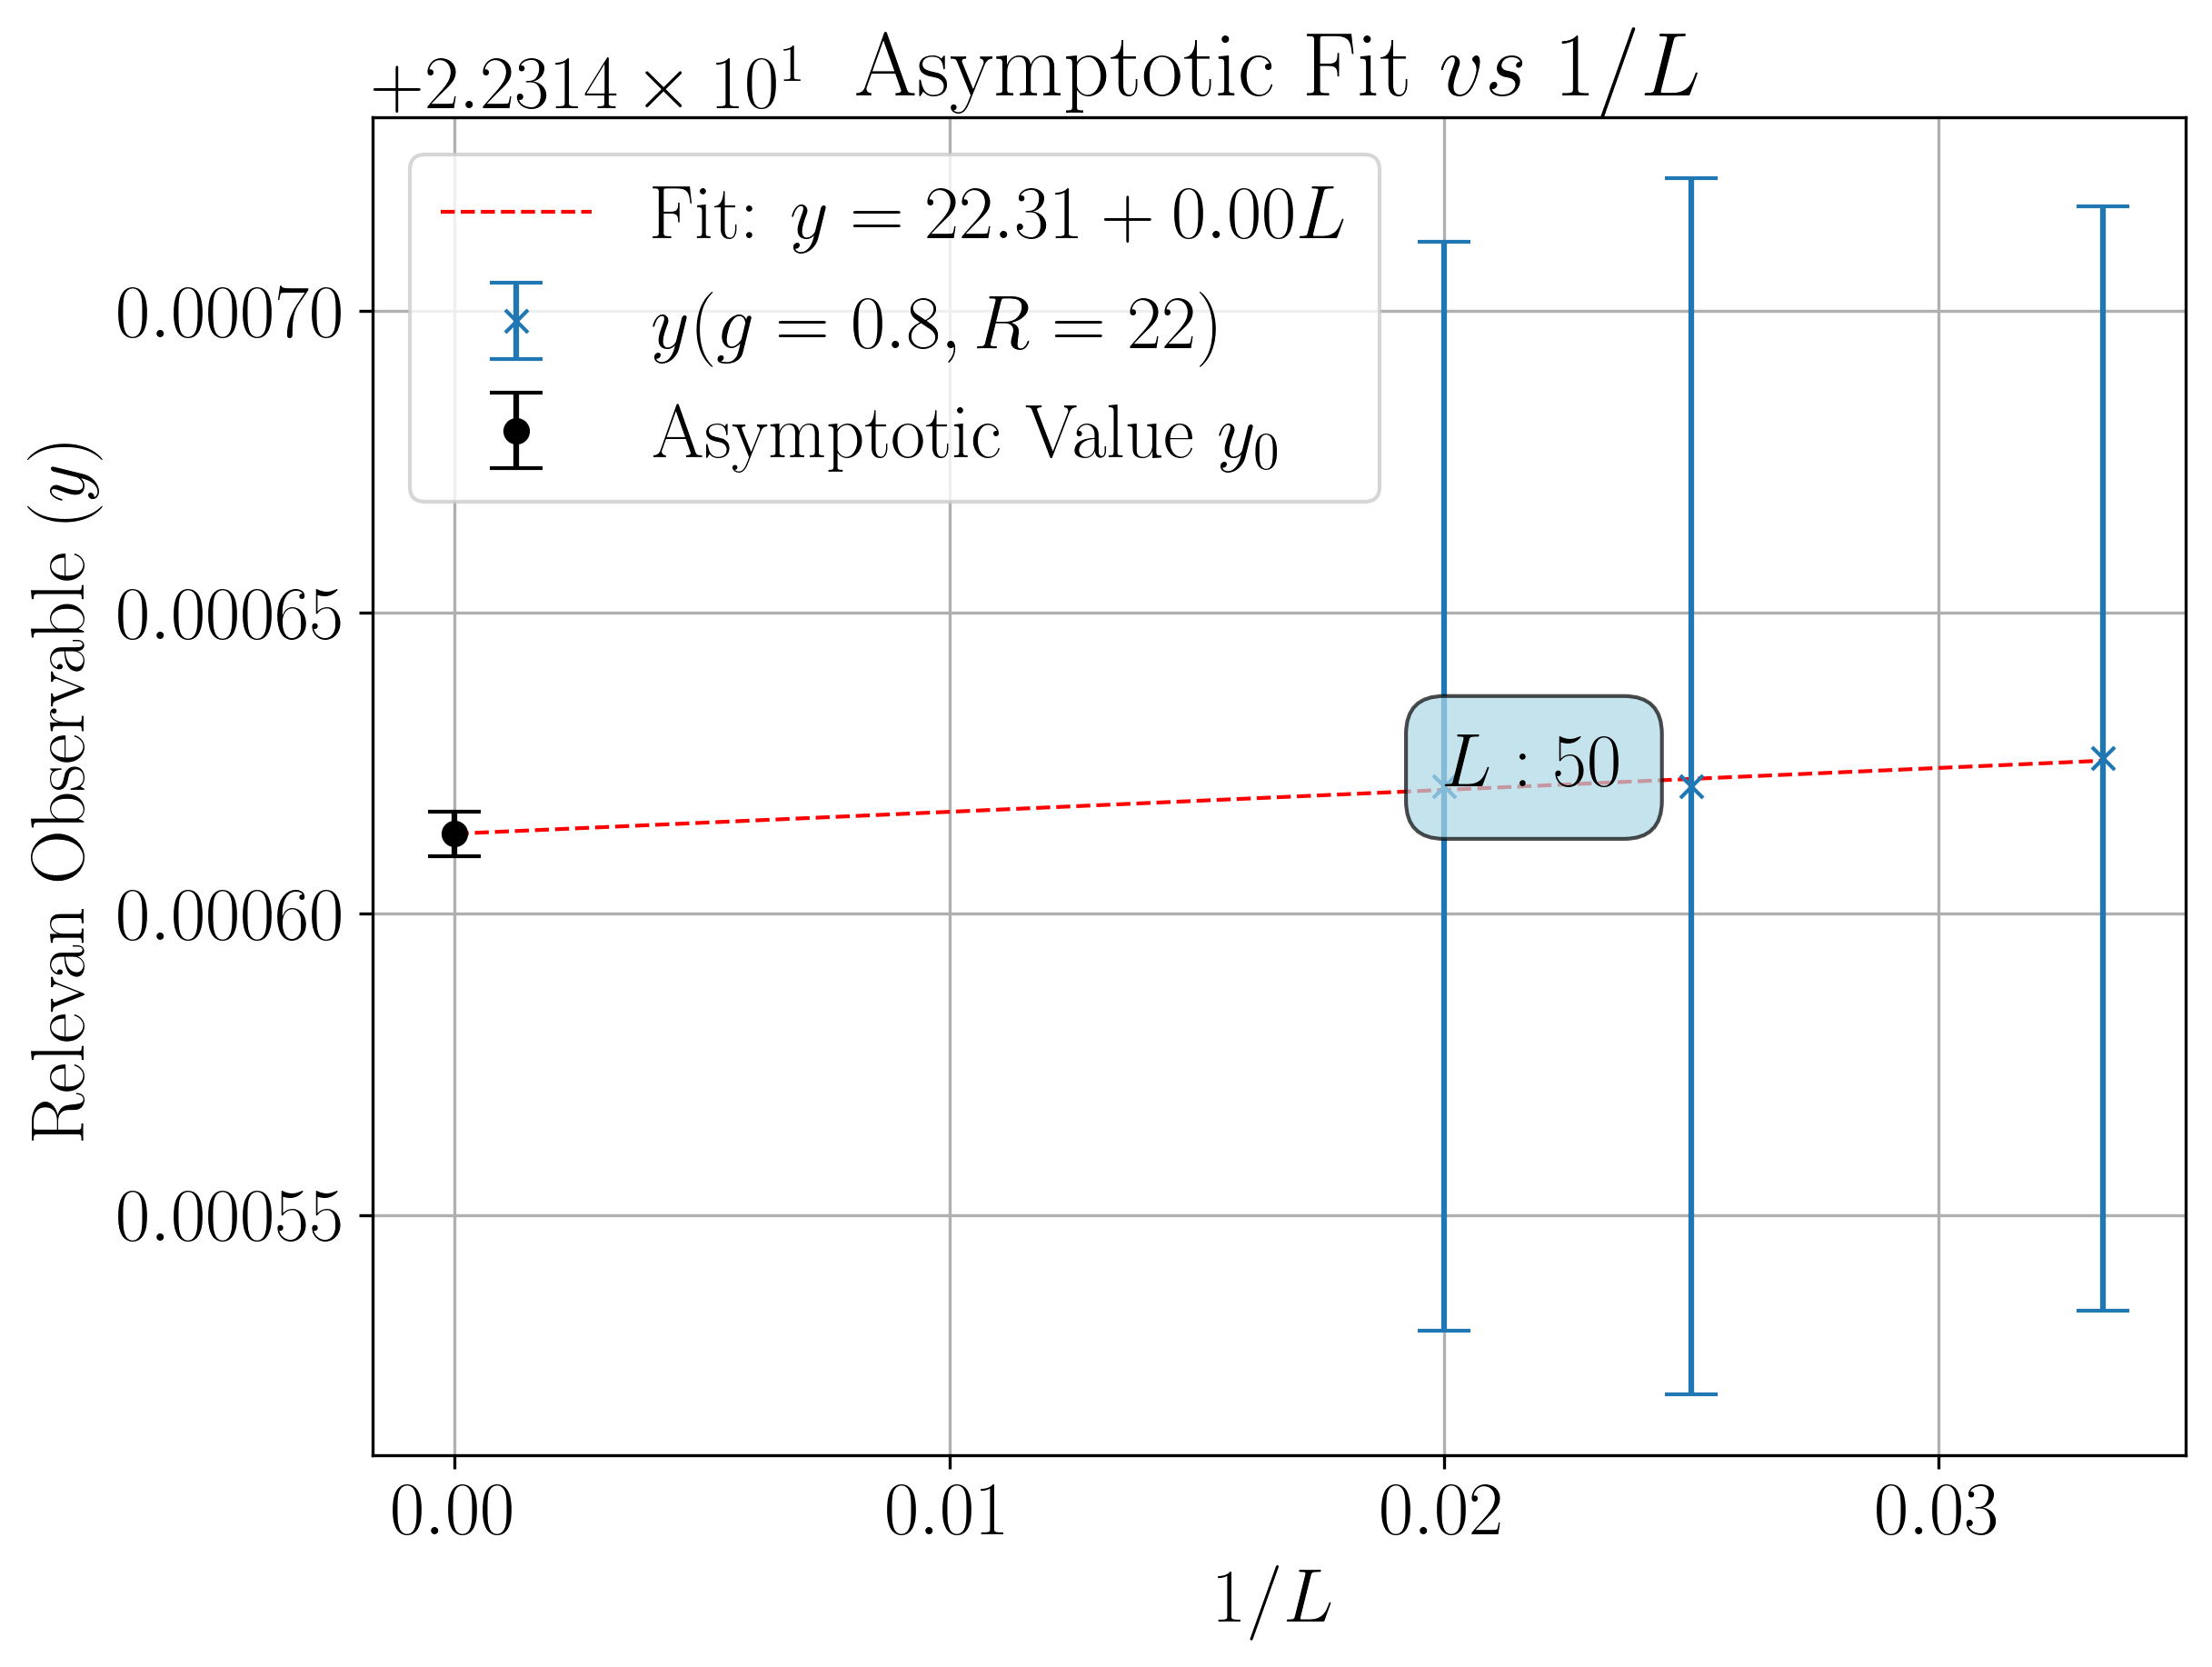

In [9]:
popt, errs = asymptotic_fit(potentials, Ls, 'L', y_err=err_L, fit_func="lin")
plot_asymptotic_fit(potentials, Ls, 'L', popt, errs, y_err=err_L, fit_func="lin", fixed_params=[g,R,l,L])

When $R$ is deep in the bulk of the lattice, we are safe from longitudinal boundary effects. By deep, we mean that the ratio $r=R/L<r_{thr}$ is smaller of a threshold ratio we fix at $r_{thr}=4/5$. Thus, instead of taking a fit, we can take a simple arithmetic average and propagate the errors.

In [12]:
av, av_err = arithmetic_average(potentials, err_L)

Arithmetic Average: 22.314622678545295
Error propagation in the Average: 5.452672153812293e-05
